In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
import os
import re
import warnings

In [2]:
warnings.filterwarnings(action="ignore")

In [3]:
files=list(filter(lambda i : re.search(".csv$",i),os.listdir(os.getcwd())))
files

['hh_demographic.csv', 'product.csv', 'transaction_data.csv']

In [4]:
file_name=list(map(lambda i : re.split("\.",i)[0],files))
file_name

['hh_demographic', 'product', 'transaction_data']

In [5]:
for i,j in zip(file_name,files):
    globals()[i]=pd.read_csv(j)

In [6]:
for i in file_name:
    print("-"*50)
    print(f"|  {i}  |")
    print(globals()[i].shape)
    print("-"*50)

--------------------------------------------------
|  hh_demographic  |
(801, 8)
--------------------------------------------------
--------------------------------------------------
|  product  |
(92353, 7)
--------------------------------------------------
--------------------------------------------------
|  transaction_data  |
(2595732, 12)
--------------------------------------------------


In [7]:
for i in file_name:
    print("-"*50)
    print(f"|  {i}  |")
    print(globals()[i].isna().sum())
    print("-"*50)

--------------------------------------------------
|  hh_demographic  |
AGE_DESC               0
MARITAL_STATUS_CODE    0
INCOME_DESC            0
HOMEOWNER_DESC         0
HH_COMP_DESC           0
HOUSEHOLD_SIZE_DESC    0
KID_CATEGORY_DESC      0
household_key          0
dtype: int64
--------------------------------------------------
--------------------------------------------------
|  product  |
PRODUCT_ID              0
MANUFACTURER            0
DEPARTMENT              0
BRAND                   0
COMMODITY_DESC          0
SUB_COMMODITY_DESC      0
CURR_SIZE_OF_PRODUCT    0
dtype: int64
--------------------------------------------------
--------------------------------------------------
|  transaction_data  |
household_key        0
BASKET_ID            0
DAY                  0
PRODUCT_ID           0
QUANTITY             0
SALES_VALUE          0
STORE_ID             0
RETAIL_DISC          0
TRANS_TIME           0
WEEK_NO              0
COUPON_DISC          0
COUPON_MATCH_DISC    0
dty

In [8]:
for i in file_name:
    print("-"*50)
    print(f"|  {i}  |")
    print(globals()[i].dtypes)
    print("-"*50)

--------------------------------------------------
|  hh_demographic  |
AGE_DESC               object
MARITAL_STATUS_CODE    object
INCOME_DESC            object
HOMEOWNER_DESC         object
HH_COMP_DESC           object
HOUSEHOLD_SIZE_DESC    object
KID_CATEGORY_DESC      object
household_key           int64
dtype: object
--------------------------------------------------
--------------------------------------------------
|  product  |
PRODUCT_ID               int64
MANUFACTURER             int64
DEPARTMENT              object
BRAND                   object
COMMODITY_DESC          object
SUB_COMMODITY_DESC      object
CURR_SIZE_OF_PRODUCT    object
dtype: object
--------------------------------------------------
--------------------------------------------------
|  transaction_data  |
household_key          int64
BASKET_ID              int64
DAY                    int64
PRODUCT_ID             int64
QUANTITY               int64
SALES_VALUE          float64
STORE_ID               int64

In [9]:
for i in file_name:
    print("-"*50)
    print(f"|  {i}  |")
    print(np.any(globals()[i].duplicated()))
    print("-"*50)

--------------------------------------------------
|  hh_demographic  |
False
--------------------------------------------------
--------------------------------------------------
|  product  |
False
--------------------------------------------------
--------------------------------------------------
|  transaction_data  |
False
--------------------------------------------------


In [10]:
for i in file_name:
    globals()[i].columns=globals()[i].columns.str.lower()

In [11]:
transaction_data["product_shelf_price"]=(transaction_data["sales_value"]-
                                         (transaction_data["retail_disc"]+
                                          transaction_data["coupon_match_disc"]))/transaction_data["quantity"]

In [12]:
transaction_data["trans_time"]=transaction_data["trans_time"].astype(str).str.zfill(4)
transaction_data["trans_time"]=transaction_data["trans_time"].apply(lambda i : i[:2]+":"+i[2:])
transaction_data["trans_hour"]=pd.to_datetime(transaction_data["trans_time"],format="%H:%M").dt.hour
transaction_data["trans_time"]=pd.to_datetime(transaction_data["trans_time"],format="%H:%M").dt.time

In [13]:
mapping={"A":"Married","B":"Single","U":"Unknown"}
hh_demographic["marital_status_code"]=hh_demographic["marital_status_code"].map(mapping)

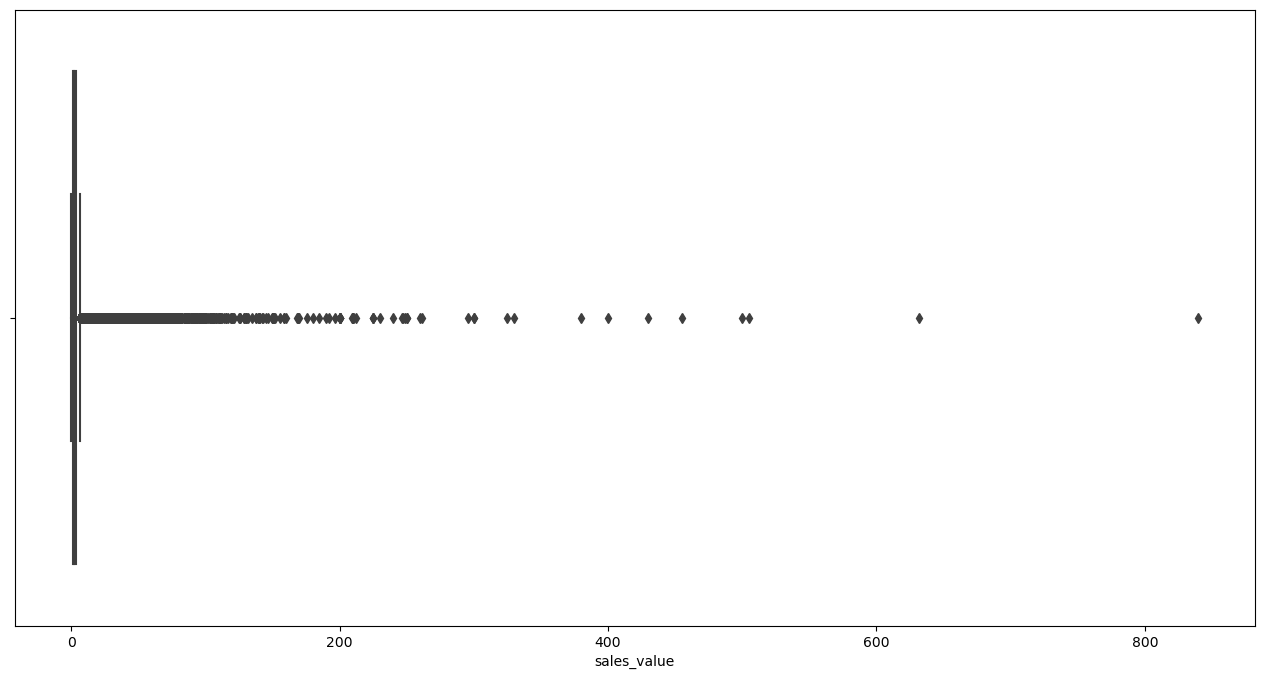

In [14]:
plt.figure(figsize=(16,8))
sns.boxplot(x=transaction_data["sales_value"])
plt.show()

# Analysing Data

### Number of Small(0-5 \\$), Medium(5-10 \\$) and Large(10+ \\$) Transactions

In [15]:
query="""
SELECT CASE
           WHEN sales_value<5 THEN 'Small'
           WHEN sales_value<10 THEN 'Medium'
           WHEN sales_value>=10 THEN 'Large'
       END AS Sales_bin,
       COUNT(DISTINCT basket_id) AS Transaction_count
FROM transaction_data
GROUP BY 1
"""

In [16]:
sales_bin_count=duckdb.sql(query).df()
sales_bin_count

,Sales_bin,Transaction_count
0,Small,241226
1,Large,69564
2,Medium,115898


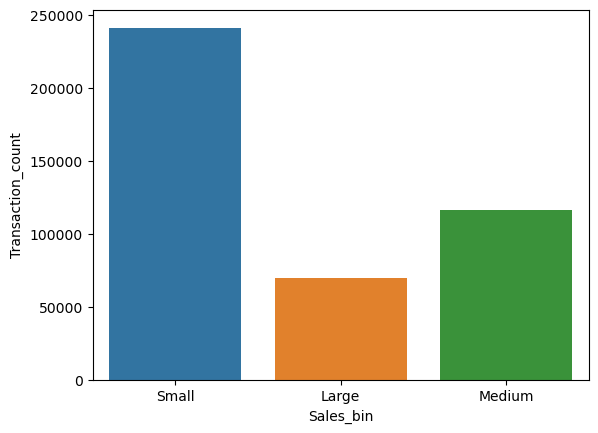

In [17]:
sns.barplot(data=sales_bin_count,x="Sales_bin",y="Transaction_count")
plt.show()

### Top 3 Stores With Highest Foot Traffic

In [18]:
query="""
WITH 
cte AS
  (SELECT store_id,week_no,
          count(distinct basket_id) AS Transaction_count
   FROM transaction_data
   GROUP BY 1,2)
SELECT store_id,
       AVG(Transaction_count) AS Avg_Transactions_Count_Per_Week
FROM cte
GROUP BY 1 
ORDER BY 2 DESC 
LIMIT 3
"""

In [19]:
top3_stores=duckdb.sql(query).df()
top3_stores

,store_id,Avg_Transactions_Count_Per_Week
0,367,75.725490
1,361,59.837209
2,343,54.691489


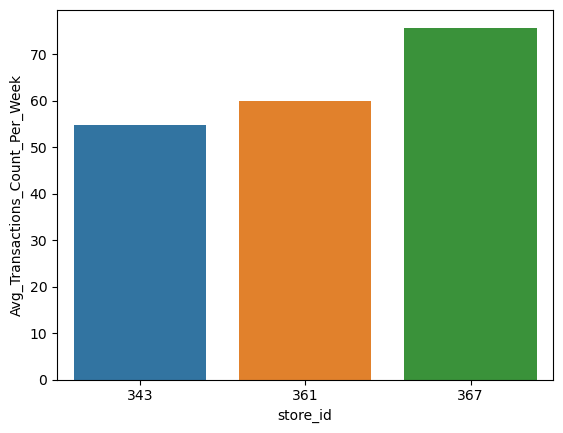

In [20]:
sns.barplot(top3_stores,x="store_id",y="Avg_Transactions_Count_Per_Week")
plt.show()

### Customer Profiling

In [21]:
query="""
WITH 
customer AS
  (SELECT household_key,
          MIN(DAY) AS First_Visit,
          MAX(DAY) AS Last_Visit,
          COUNT(DISTINCT basket_id) AS Total_Visits_Count,
          SUM(sales_value)/COUNT(DISTINCT basket_id) AS Avg_Spend_Per_Visit,
          SUM(sales_value) AS Total_Spend
   FROM transaction_data
   GROUP BY 1)
SELECT d.household_key,
       age_desc,
       marital_status_code,
       income_desc,
       homeowner_desc,
       hh_comp_desc,
       household_size_desc,
       kid_category_desc,
       First_Visit,
       Last_Visit,
       Total_Visits_Count,
       Avg_Spend_Per_Visit,
       Total_Spend
FROM customer c
JOIN hh_demographic d ON c.household_key=d.household_key
ORDER BY Total_Spend DESC;
"""

In [22]:
spenders=duckdb.sql(query).df()
spenders

,household_key,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,First_Visit,Last_Visit,Total_Visits_Count,Avg_Spend_Per_Visit,Total_Spend
0,1609,45-54,Married,125-149K,Homeowner,2 Adults Kids,5+,3+,42,711,412,67.620583,27859.68
1,2322,45-54,Unknown,175-199K,Homeowner,Single Male,1,None/Unknown,66,711,323,73.210279,23646.92
2,1453,45-54,Married,125-149K,Homeowner,2 Adults Kids,3,1,97,710,761,28.464244,21661.29
3,1430,35-44,Married,35-49K,Homeowner,2 Adults Kids,3,1,76,711,344,59.165669,20352.99
4,718,45-54,Married,25-34K,Homeowner,2 Adults Kids,5+,3+,1,707,599,32.220134,19299.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,1429,45-54,Single,35-49K,Renter,Single Female,1,None/Unknown,115,710,83,9.862169,818.56
797,1604,35-44,Unknown,35-49K,Probable Owner,2 Adults No Kids,2,None/Unknown,106,711,156,5.246218,818.41
798,460,65+,Single,25-34K,Homeowner,Single Female,1,None/Unknown,79,707,113,6.729646,760.45
799,1135,45-54,Unknown,50-74K,Unknown,Unknown,2,1,29,706,64,11.701250,748.88


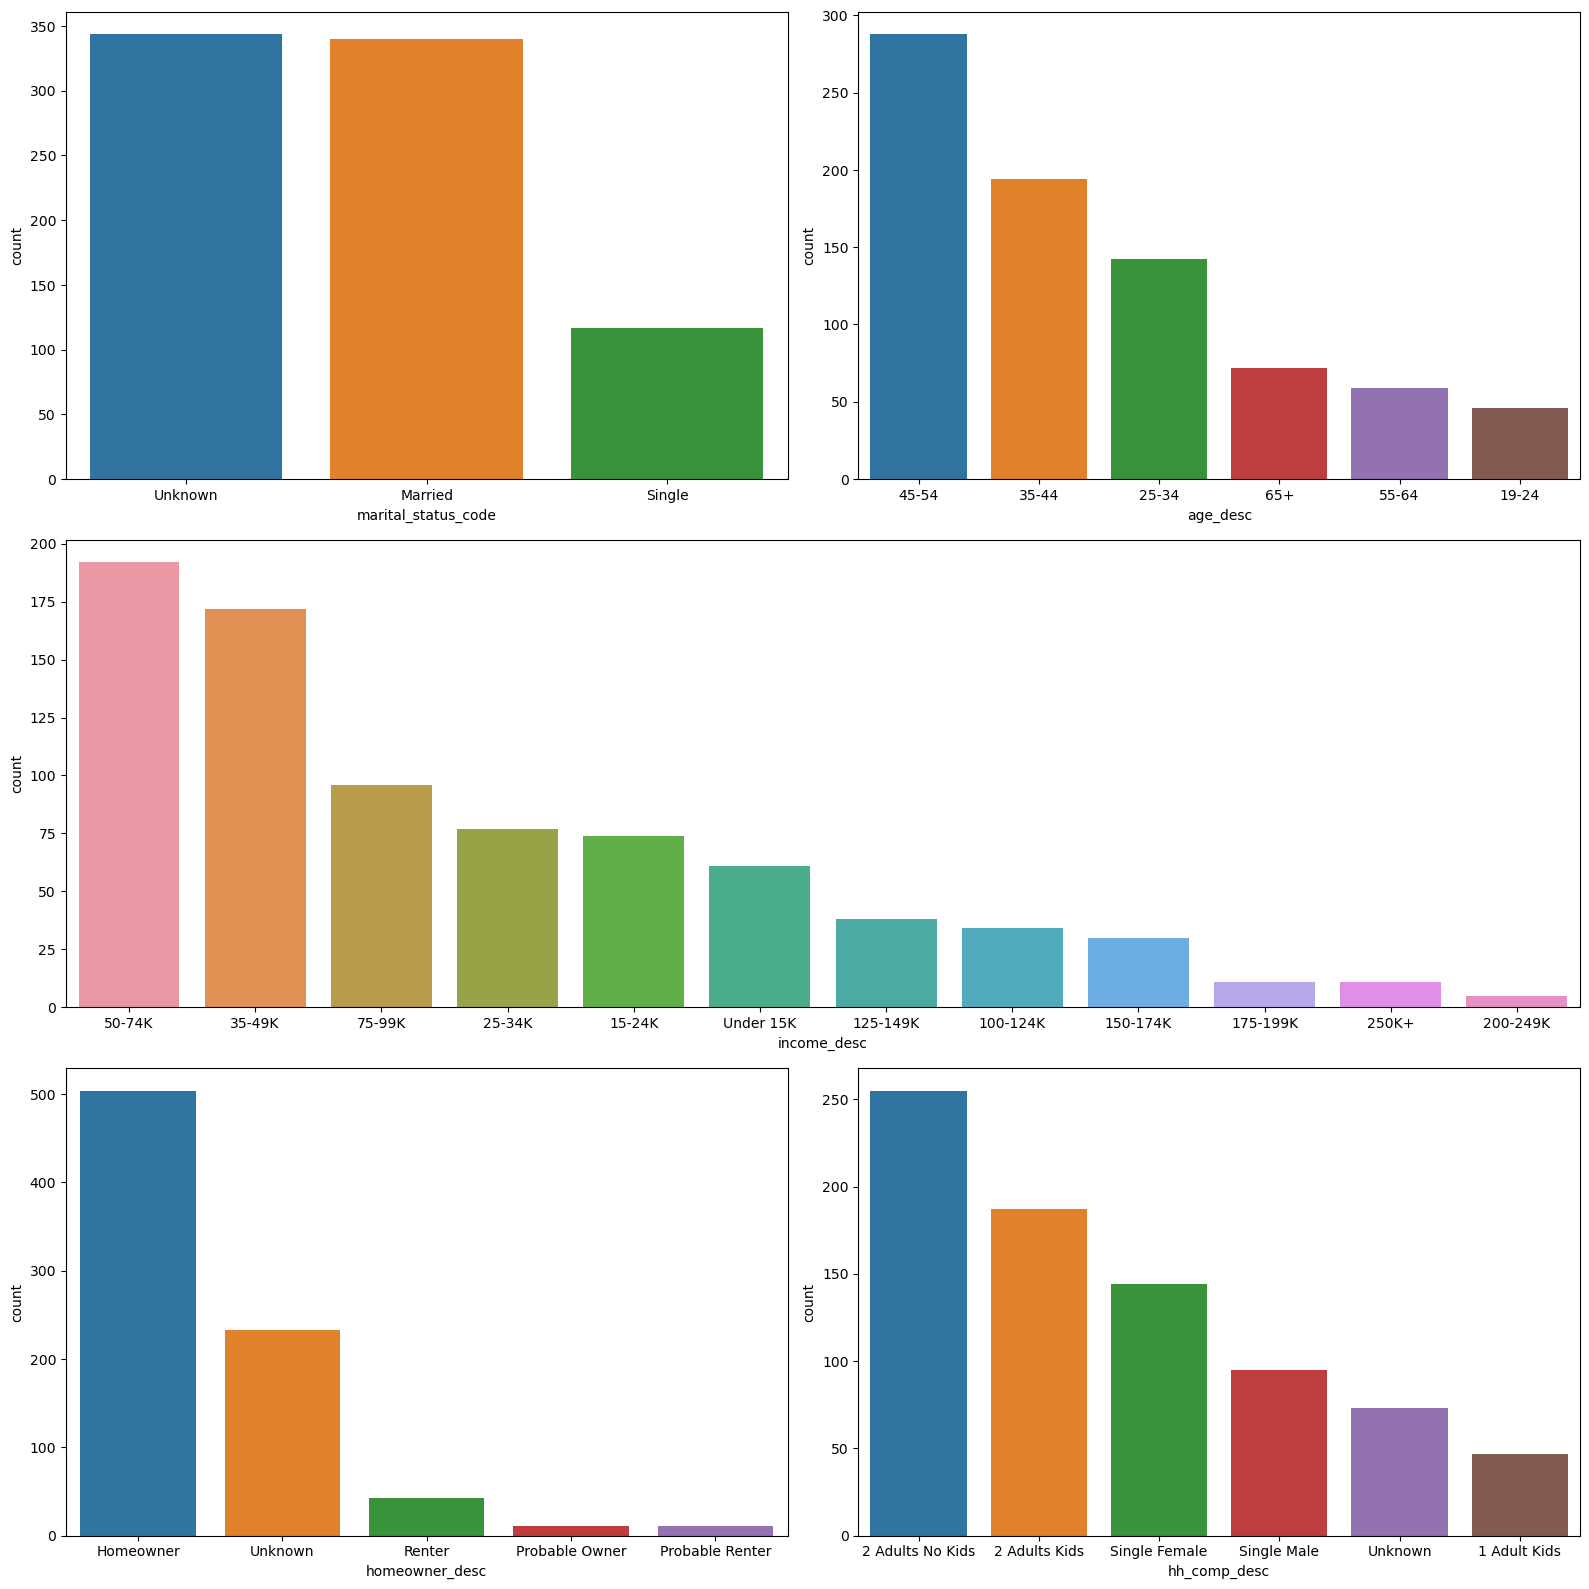

In [23]:
plt.figure(0,figsize=(16,16))
plt.subplot(321)
sns.countplot(data=spenders,x="marital_status_code",order=spenders["marital_status_code"].value_counts().index)
plt.subplot(322)
sns.countplot(data=spenders,x="age_desc",order=spenders["age_desc"].value_counts().index)
plt.subplot(312)
sns.countplot(data=spenders,x="income_desc",order=spenders["income_desc"].value_counts().index)
plt.subplot(325)
sns.countplot(data=spenders,x="homeowner_desc",order=spenders["homeowner_desc"].value_counts().index)
plt.subplot(326)
sns.countplot(data=spenders,x="hh_comp_desc",order=spenders["hh_comp_desc"].value_counts().index)
plt.tight_layout()

### Top Selling Products(Contributing to 80% of the Revenue) And Revenue Generated

In [24]:
query="""
WITH 
cte AS (
   SELECT product_id,
          SUM(quantity) AS Total_quantity_sold,
          SUM(sales_value) AS Total_sales_value
   FROM transaction_data
   GROUP BY 1),
cte1 AS (
   SELECT *,
          SUM(Total_sales_value) OVER (ORDER BY Total_sales_value DESC) AS rolling_sum,
          SUM(Total_sales_value) OVER () AS total_sales
   FROM cte),
cte2 AS (
   SELECT product_id,
          Total_quantity_sold,
          Total_sales_value
   FROM cte1
   WHERE rolling_sum/total_sales<=0.80)
SELECT p.*,
       Total_quantity_sold,
       Total_sales_value
FROM product p
JOIN cte2 c2 ON c2.product_id=p.product_id
WHERE Total_quantity_sold!=0
ORDER BY Total_sales_value DESC;
"""

In [25]:
top_selling_products=duckdb.sql(query).df()
top_selling_products

,product_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,Total_quantity_sold,Total_sales_value
0,6534178,69,KIOSK-GAS,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,,216532156.0,503867.11
1,6533889,69,MISC SALES TRAN,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,,18479630.0,46311.32
2,1029743,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA,16976.0,41072.06
3,6534166,69,MISC SALES TRAN,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,,13980451.0,33594.48
4,1082185,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB,30896.0,29482.00
...,...,...,...,...,...,...,...,...,...
11858,5716076,69,KIOSK-GAS,Private,FUEL,GASOLINE-REG UNLEADED,,47710.0,126.01
11859,1002765,1251,GROCERY,National,SOUP,CONDENSED SOUP,10.75 OZ,84.0,126.01
11860,827631,2150,GROCERY,National,BAG SNACKS,PRETZELS,15 OZ,66.0,126.01
11861,988778,36,GROCERY,National,PICKLE/RELISH/PKLD VEG,PICKLD VEG PEPPERS ETC,12 OZ,75.0,126.00


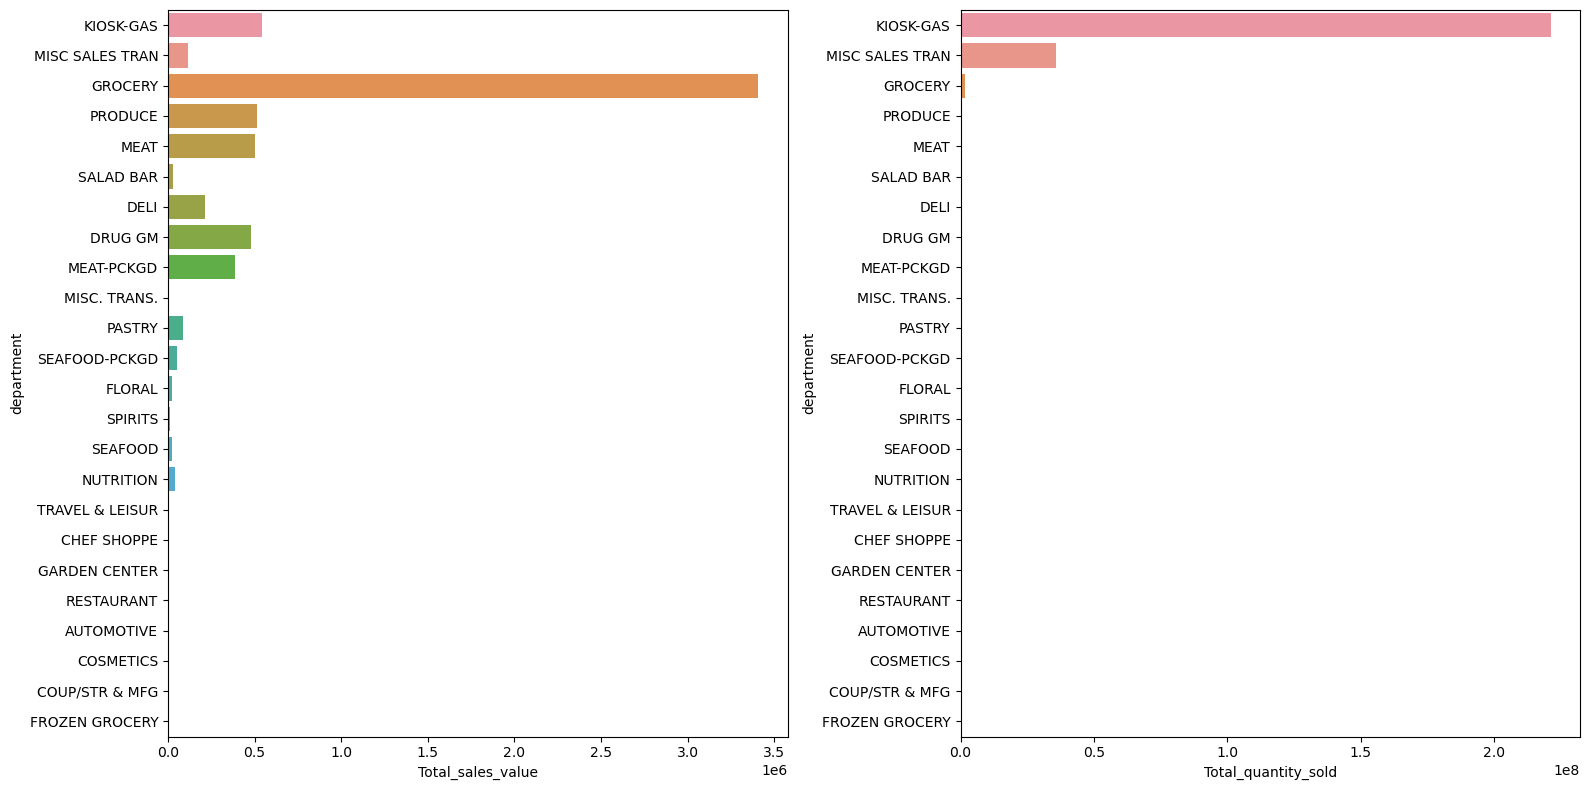

In [26]:
plt.figure(0,figsize=(16,8))
plt.subplot(121)
sns.barplot(data=top_selling_products,x="Total_sales_value",y="department",estimator="sum",errorbar=None)
plt.subplot(122)
sns.barplot(data=top_selling_products,x="Total_quantity_sold",y="department",estimator="sum",errorbar=None)
plt.tight_layout()

##### Analyzing Top 10 Manufacturers

In [27]:
query="""
SELECT manufacturer,
       SUM(Total_quantity_sold) AS Total_quantity_sold,
       SUM(Total_sales_value) AS Total_sales_value
FROM top_selling_products
GROUP BY 1
ORDER BY 3 DESC
LIMIT 10
"""

In [28]:
top10_manufacturers=duckdb.sql(query).df()
top10_manufacturers

,manufacturer,Total_quantity_sold,Total_sales_value
0,69,257878304.0,1966193.35
1,2,219305.0,332283.77
2,764,25111.0,132793.20
3,103,49228.0,110846.14
4,1208,46958.0,108537.73
5,317,46765.0,93666.11
6,544,49834.0,89559.16
7,1251,49551.0,75422.32
8,673,26119.0,72050.00
9,239,7339.0,61269.53


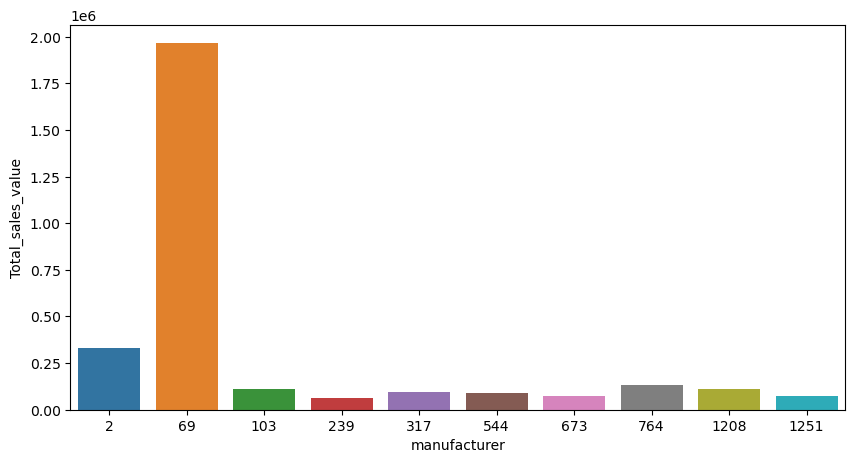

In [29]:
plt.figure(figsize=(10,5))
sns.barplot(top10_manufacturers,x="manufacturer",y="Total_sales_value")
plt.show()

### Week over Week Cumulative Spending For each Household

In [30]:
query="""
WITH
cte AS
  (SELECT household_key,
          week_no,
          SUM(sales_value) AS weekly_sales
   FROM transaction_data
   GROUP BY 1,2)
SELECT household_key,
       week_no,
       weekly_sales,
       SUM(weekly_sales) OVER (PARTITION BY household_key ORDER BY week_no) AS rolling_weekly_sales
FROM cte
"""

In [31]:
weekly_sales=duckdb.sql(query).df()
weekly_sales

,household_key,week_no,weekly_sales,rolling_weekly_sales
0,55,10,25.28,25.28
1,55,12,12.51,37.79
2,55,14,15.27,53.06
3,55,15,21.16,74.22
4,55,18,22.99,97.21
...,...,...,...,...
123971,2463,37,9.09,34.98
123972,2463,42,21.41,56.39
123973,2463,53,52.27,108.66
123974,2463,54,22.00,130.66


#### Top 10 Spender's Week over Week Cumulative Spending

In [32]:
query="""
WITH 
top10_spenders AS (SELECT *
                 FROM spenders 
                 ORDER BY Total_Spend DESC
                 LIMIT 10)
SELECT household_key,
       week_no,
       weekly_sales,
       rolling_weekly_sales
FROM weekly_sales
WHERE household_key IN
    (SELECT household_key
     FROM top10_spenders)
"""

In [33]:
top10_weekly_sales=duckdb.sql(query).df()
top10_weekly_sales

,household_key,week_no,weekly_sales,rolling_weekly_sales
0,1430,12,199.09,199.09
1,1430,13,115.75,314.84
2,1430,14,208.09,522.93
3,1430,15,234.59,757.52
4,1430,16,231.05,988.57
...,...,...,...,...
908,982,98,268.24,17872.25
909,982,99,339.10,18211.35
910,982,100,139.47,18350.82
911,982,101,228.86,18579.68


In [34]:
query="""
WITH RECURSIVE dx AS
  (SELECT household_key,
          min(week_no) AS minw,
          max(week_no) AS maxw
   FROM transaction_data
   GROUP BY 1),
               cte AS
  (SELECT household_key,
          minw,
          maxw
   FROM dx
   UNION ALL SELECT household_key,
                    minw+1,
                    maxw
   FROM cte c
   WHERE minw<maxw)
SELECT household_key,minw as week_no
FROM cte
ORDER BY 1,2
"""

In [35]:
all_weeks=duckdb.sql(query).df()
all_weeks

,household_key,week_no
0,1,8
1,1,9
2,1,10
3,1,11
4,1,12
...,...,...
223659,2500,98
223660,2500,99
223661,2500,100
223662,2500,101


In [36]:
query="""
SELECT aw.household_key,
       aw.week_no,
       ROUND(IFNULL(weekly_sales,0),2) AS weekly_sales,
       ROUND(IFNULL(rolling_weekly_sales,0),2) AS rolling_weekly_sales
FROM all_weeks aw
       LEFT JOIN top10_weekly_sales ws ON aw.household_key=ws.household_key
                                            AND aw.week_no=ws.week_no
WHERE aw.household_key in (SELECT household_key FROM top10_weekly_sales)
ORDER BY 1,2;
"""

In [37]:
top10_rollingsales=duckdb.sql(query).df()
top10_rollingsales

,household_key,week_no,weekly_sales,rolling_weekly_sales
0,400,16,30.22,30.22
1,400,17,0.00,0.00
2,400,18,29.66,59.88
3,400,19,0.00,0.00
4,400,20,190.52,250.40
...,...,...,...,...
920,2322,98,133.41,23300.10
921,2322,99,77.51,23377.61
922,2322,100,177.44,23555.05
923,2322,101,21.26,23576.31


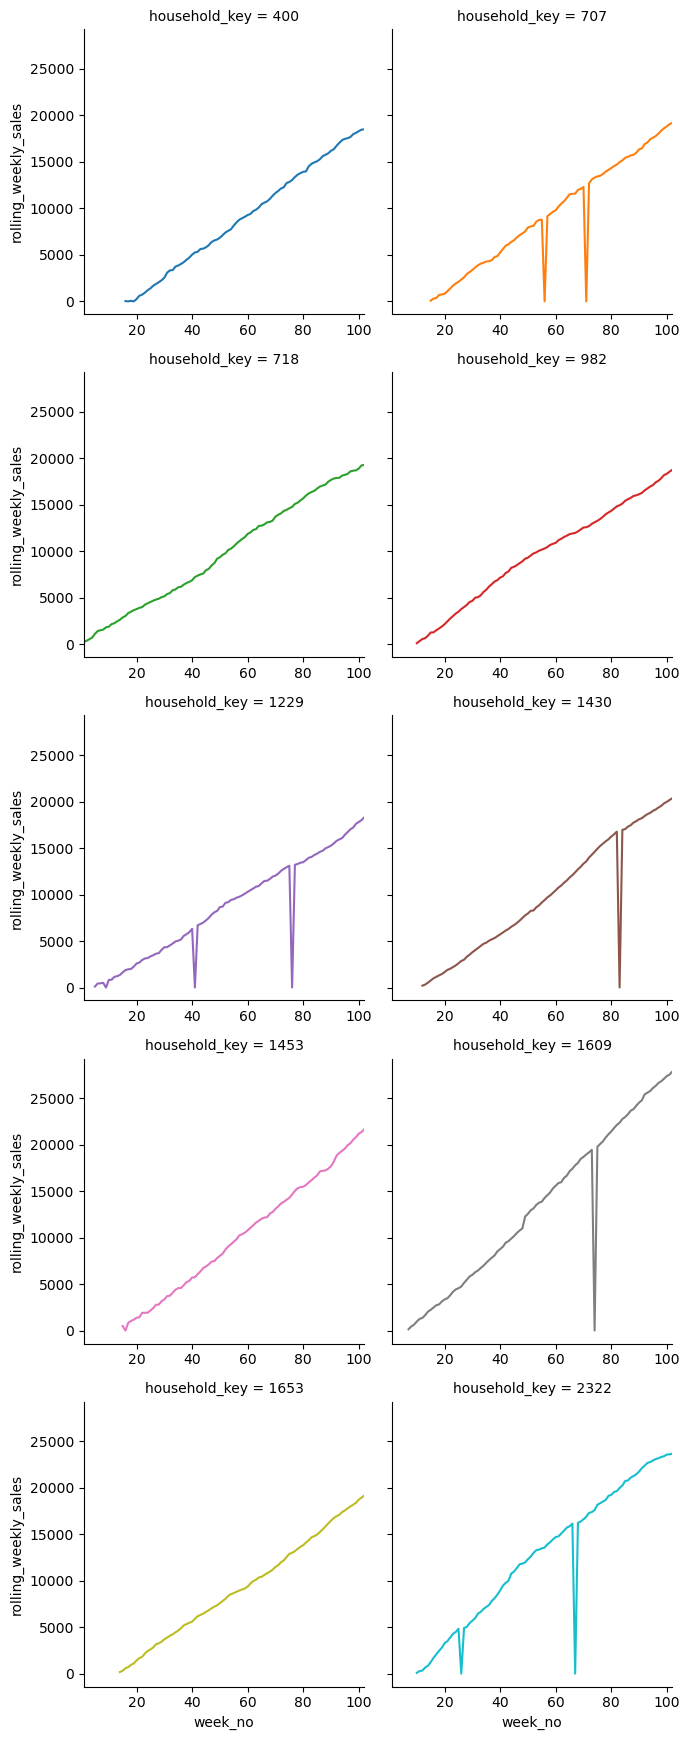

In [38]:
sns.FacetGrid(data=top10_rollingsales,col="household_key",col_wrap=2,height=3.5
              ,sharex=False,hue="household_key",xlim=[1,102]).map(sns.lineplot,"week_no","rolling_weekly_sales")
plt.show()

### Number of Transactions per Week Vs Transaction Hour

In [39]:
query="""
SELECT trans_hour,
       COUNT(DISTINCT basket_id)/(SELECT MAX(week_no) FROM transaction_data) AS Transactions_Count_per_week
FROM transaction_data
GROUP BY 1
ORDER BY 1;
"""

In [40]:
hourly_transactions=duckdb.sql(query).df()
hourly_transactions

,trans_hour,Transactions_Count_per_week
0,0,20.117647
1,1,9.784314
2,2,10.960784
3,3,4.813725
4,4,3.647059
5,5,6.264706
6,6,18.137255
7,7,37.078431
8,8,55.480392
9,9,80.656863


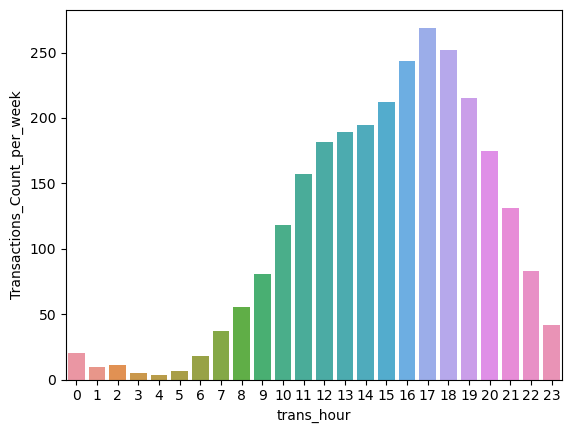

In [41]:
sns.barplot(hourly_transactions,x="trans_hour",y="Transactions_Count_per_week")
plt.show()

### Week over week Relative Change in Spending of Customers 

In [42]:
query="""
WITH 
cte AS
  (SELECT household_key,
          week_no,
          weekly_sales,
          LAG(weekly_sales) OVER (PARTITION BY household_key
                                  ORDER BY week_no) AS prev_week_sales
   FROM weekly_sales)
SELECT household_key,
       week_no,
       weekly_sales,
       prev_week_sales,
       (weekly_sales-prev_week_sales)/prev_week_sales AS Relative_change
FROM cte
"""

In [43]:
weekly_percent_change=duckdb.sql(query).df()
weekly_percent_change

,household_key,week_no,weekly_sales,prev_week_sales,Relative_change
0,11,16,13.94,NaN,NaN
1,11,18,4.11,13.94,-0.705165
2,11,31,5.29,4.11,0.287105
3,11,58,4.70,5.29,-0.111531
4,11,60,5.35,4.70,0.138298
...,...,...,...,...,...
123971,2496,89,112.39,135.78,-0.172264
123972,2496,91,84.39,112.39,-0.249132
123973,2496,95,10.00,84.39,-0.881503
123974,2496,97,109.32,10.00,9.932000


In [44]:
query="""
WITH 
top10_spenders AS (SELECT *
                 FROM spenders 
                 ORDER BY Total_Spend DESC
                 LIMIT 10)
SELECT *
FROM weekly_percent_change
WHERE household_key IN 
                 (SELECT household_key 
                  FROM top10_spenders)
ORDER BY household_key,week_no;
"""

In [45]:
top10_weekly_percent_change=duckdb.sql(query).df()
top10_weekly_percent_change

,household_key,week_no,weekly_sales,prev_week_sales,Relative_change
0,400,16,30.22,NaN,NaN
1,400,18,29.66,30.22,-0.018531
2,400,20,190.52,29.66,5.423466
3,400,21,352.70,190.52,0.851249
4,400,22,120.91,352.70,-0.657187
...,...,...,...,...,...
908,2322,98,133.41,95.09,0.402987
909,2322,99,77.51,133.41,-0.419009
910,2322,100,177.44,77.51,1.289253
911,2322,101,21.26,177.44,-0.880185


### Retention Table

In [46]:
query="""
WITH 
cte AS
  (SELECT household_key,
          basket_id,
          week_no
   FROM transaction_data
   GROUP BY 1,2,3),
cte1 AS
  (SELECT *,
          MIN(week_no) OVER (PARTITION BY household_key) AS first_transaction_week
   FROM cte),
cte2 AS
  (SELECT first_transaction_week,
          week_no,
          count(DISTINCT household_key) AS num_transactions
   FROM cte1
   GROUP BY 1,2
   ORDER BY 1,2)
SELECT first_transaction_week,
       week_no,
       num_transactions/NTH_VALUE(num_transactions, 1) OVER (PARTITION BY first_transaction_week
                                                             ORDER BY week_no)*100 AS return_rate
FROM cte2
ORDER BY 1,2;
"""

In [47]:
return_rate=duckdb.sql(query).df()
return_rate

,first_transaction_week,week_no,return_rate
0,1,1,100.000000
1,1,2,52.272727
2,1,3,52.272727
3,1,4,48.863636
4,1,5,48.863636
...,...,...,...
1885,88,88,100.000000
1886,88,90,100.000000
1887,88,93,100.000000
1888,97,97,100.000000


In [48]:
return_rate.pivot(index="first_transaction_week",columns="week_no",values="return_rate")

week_no,1,2,3,4,5,6,7,8,9,10,...,93,94,95,96,97,98,99,100,101,102
first_transaction_week,,,,,,,,,,,,,,,,,,,,,
1,100.0,52.272727,52.272727,48.863636,48.863636,54.545455,51.136364,50.000000,46.590909,51.136364,...,46.590909,56.818182,53.409091,53.409091,47.727273,56.818182,50.000000,53.409091,54.545455,39.772727
2,NaN,100.000000,53.488372,48.837209,51.937984,57.364341,50.387597,45.736434,52.713178,51.162791,...,50.387597,54.263566,53.488372,55.813953,51.937984,55.813953,56.589147,60.465116,57.364341,52.713178
3,NaN,NaN,100.000000,40.707965,51.327434,53.982301,47.787611,46.902655,43.362832,48.672566,...,52.212389,57.522124,61.061947,57.522124,53.982301,57.522124,54.867257,53.097345,47.787611,46.902655
4,NaN,NaN,NaN,100.000000,54.237288,55.932203,55.932203,47.457627,56.779661,56.779661,...,49.152542,55.932203,61.864407,57.627119,55.084746,54.237288,54.237288,52.542373,52.542373,47.457627
5,NaN,NaN,NaN,NaN,100.000000,47.101449,49.275362,46.376812,51.449275,54.347826,...,53.623188,54.347826,55.072464,52.173913,46.376812,54.347826,47.826087,45.652174,45.652174,50.724638
6,NaN,NaN,NaN,NaN,NaN,100.000000,52.100840,42.016807,55.462185,47.899160,...,48.739496,44.537815,52.100840,45.378151,46.218487,53.781513,48.739496,52.100840,49.579832,46.218487
7,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,54.961832,51.908397,54.198473,...,51.145038,54.198473,45.038168,46.564885,45.801527,45.801527,44.274809,40.458015,42.748092,45.801527
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,47.727273,48.484848,...,47.727273,55.303030,56.060606,51.515152,55.303030,61.363636,52.272727,51.515152,53.030303,50.000000
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,52.713178,...,44.186047,50.387597,50.387597,47.286822,50.387597,49.612403,48.062016,42.635659,37.984496,40.310078


### Quarter Over Quarter Relative Change in Total Sales 

In [49]:
query="""
WITH 
cte AS
  (SELECT CAST((CEIL(week_no/12)) AS INT) AS Quarter,
          ROUND(SUM(sales_value), 2) AS total_sales
   FROM transaction_data
   GROUP BY 1
   ORDER BY 1),
cte1 AS
  (SELECT *,
          LAG(total_sales) OVER (ORDER BY Quarter) AS prev_quarter_sales
   FROM cte)
SELECT Quarter,
       total_sales,
       (total_sales-prev_quarter_sales)/prev_quarter_sales AS relative_change
FROM cte1;
"""

In [50]:
duckdb.sql(query).df()

,Quarter,total_sales,relative_change
0,1,328865.31,NaN
1,2,912816.42,1.775654
2,3,984673.83,0.078721
3,4,1040395.39,0.056589
4,5,1047704.20,0.007025
5,6,1068965.30,0.020293
6,7,1030379.30,-0.036097
7,8,1105071.55,0.072490
8,9,538591.78,-0.512618


### Quarter Over Quarter Relative Change in Total Sales for each Store

In [51]:
query="""
WITH 
cte AS
  (SELECT store_id,
          CAST(CEIL(week_no/12) AS INT) AS Quarter,
          sum(sales_value) AS total_sales
   FROM transaction_data
   GROUP BY 1,2),
cte1 AS
  (SELECT *,
          lag(total_sales) OVER (PARTITION BY store_id ORDER BY Quarter) AS prev_quarter_sales
   FROM cte)
SELECT store_id,
       Quarter,
       total_sales,
       (total_sales-prev_quarter_sales)/prev_quarter_sales AS Relative_change
FROM cte1;
"""

In [52]:
duckdb.sql(query).df()

,store_id,Quarter,total_sales,Relative_change
0,22,3,24.77,NaN
1,81,7,16.61,NaN
2,132,2,23.02,NaN
3,132,4,6.59,-0.713727
4,132,7,20.41,2.097117
...,...,...,...,...
2232,31822,9,139.73,0.694313
2233,34011,6,4098.34,NaN
2234,34011,7,15638.03,2.815699
2235,34011,8,15685.03,0.003005


### Customers who shopped just once

In [53]:
query="""
WITH 
cte AS
  (SELECT household_key,
          CAST(CEIL(week_no/12) AS INT) AS Quarter
   FROM transaction_data
   GROUP BY 1,2),
cte1 AS
  (SELECT household_key,
          MIN(Quarter) AS first_sales_quarter,
          MAX(Quarter) AS last_sales_quarter
   FROM cte
   GROUP BY 1)
SELECT household_key,
       first_sales_quarter
FROM cte1
WHERE first_sales_quarter=last_sales_quarter ;
"""

In [54]:
duckdb.sql(query).df()

,household_key,first_sales_quarter
0,1727,2
1,494,2
2,1830,1
3,1984,8
4,2201,1
5,2325,9
6,2265,1
7,359,1
8,1897,1


### Quarterly Retention Table 

In [55]:
query="""
WITH 
cte AS
  (SELECT household_key,
          basket_id,
          CAST(CEIL(week_no/12) AS INT) AS Quarter
   FROM transaction_data
   GROUP BY 1,2,3),
cte1 AS
  (SELECT household_key,
          MIN(Quarter) OVER (PARTITION BY household_key) AS first_sales_quarter,
          Quarter
   FROM cte),
cte2 AS
  (SELECT first_sales_quarter,
          Quarter,
          count(DISTINCT household_key) AS cnt
   FROM cte1
   GROUP BY 1,2
   ORDER BY 1,2),
cte3 AS
  (SELECT first_sales_quarter,
          Quarter,
          cnt/NTH_VALUE(cnt, 1) OVER (PARTITION BY first_sales_quarter
                                      ORDER BY Quarter)*100 AS retention_rate
   FROM cte2)
SELECT first_sales_quarter,
       SUM(CASE WHEN Quarter=1 THEN retention_rate ELSE 0 END) AS '1',
       SUM(CASE WHEN Quarter=2 THEN retention_rate ELSE 0 END) AS '2',
       SUM(CASE WHEN Quarter=3 THEN retention_rate ELSE 0 END) AS '3',
       SUM(CASE WHEN Quarter=4 THEN retention_rate ELSE 0 END) AS '4',
       SUM(CASE WHEN Quarter=5 THEN retention_rate ELSE 0 END) AS '5',
       SUM(CASE WHEN Quarter=6 THEN retention_rate ELSE 0 END) AS '6',
       SUM(CASE WHEN Quarter=7 THEN retention_rate ELSE 0 END) AS '7',
       SUM(CASE WHEN Quarter=8 THEN retention_rate ELSE 0 END) AS '8',
       SUM(CASE WHEN Quarter=9 THEN retention_rate ELSE 0 END) AS '9'
FROM cte3
GROUP BY 1
ORDER BY 1;
"""

In [56]:
quarterly_retention_rate=duckdb.sql(query).df().set_index("first_sales_quarter")
quarterly_retention_rate

,1,2,3,4,5,6,7,8,9
first_sales_quarter,,,,,,,,,
1,100.0,92.249527,90.611216,90.044108,91.115312,91.997480,91.934468,92.501575,84.940139
2,0.0,100.000000,91.510474,91.069460,91.400221,92.061742,91.620728,93.825799,86.218302
3,0.0,0.000000,100.000000,50.000000,100.000000,0.000000,50.000000,50.000000,50.000000
4,0.0,0.000000,0.000000,100.000000,0.000000,100.000000,100.000000,100.000000,100.000000
6,0.0,0.000000,0.000000,0.000000,0.000000,100.000000,100.000000,100.000000,100.000000
8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000
9,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000


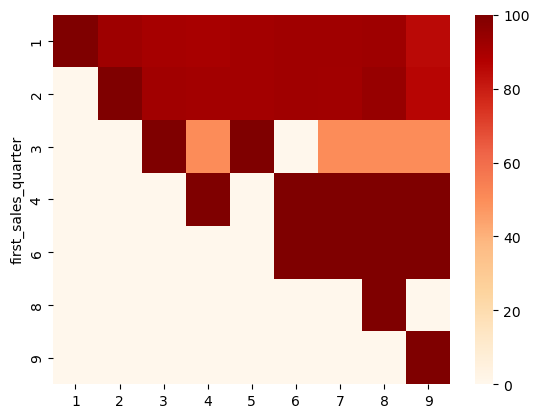

In [57]:
sns.heatmap(quarterly_retention_rate,cmap="OrRd")
plt.show()

### Churn For each Quarter

In [58]:
query="""
WITH 
cte AS
  (SELECT basket_id,
          household_key,
          CAST(CEIL(week_no/12) AS INT) AS Quarter
   FROM transaction_data
   GROUP BY 1,2,3),
cte1 AS
  (SELECT household_key,
          Quarter,
          max(QUARTER) OVER (PARTITION BY HOUSEHOLD_KEY) AS last_sales_quarter
   FROM cte)
SELECT last_sales_quarter,
       COUNT(DISTINCT household_key) AS churned
FROM cte1
WHERE last_sales_quarter<(SELECT MAX(Quarter)
                          FROM cte1)
GROUP BY 1
ORDER BY 1;
"""

In [59]:
churn=duckdb.sql(query).df()
churn

,last_sales_quarter,churned
0,1,5
1,2,3
2,3,4
3,4,7
4,5,13
5,6,27
6,7,54
7,8,253


<Axes: xlabel='last_sales_quarter', ylabel='churned'>

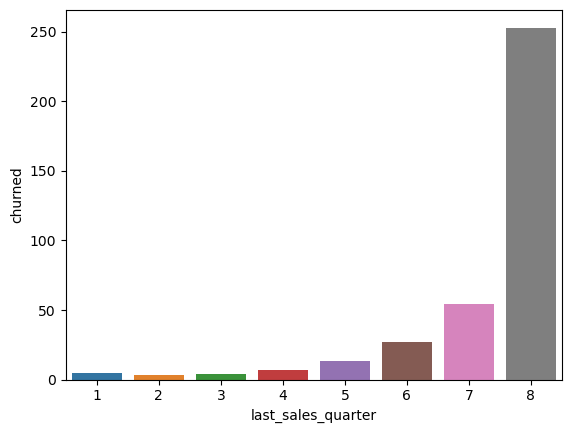

In [60]:
sns.barplot(data=churn,x="last_sales_quarter",y="churned")

### Analysing Customer Lifetime Value For different age groups

In [61]:
query="""
WITH 
cte AS
  (SELECT household_key,
          max(week_no)-min(week_no) AS customer_duration
   FROM transaction_data
   GROUP BY 1),
cte1 AS
  (SELECT age_desc,
          SUM(customer_duration)/COUNT(d.household_key) AS Avg_customer_lifespan
   FROM cte c JOIN hh_demographic d ON c.household_key=d.household_key
   GROUP BY 1),
cte2 AS
  (SELECT age_desc,
          SUM(sales_value)/count(DISTINCT basket_id) AS Avg_purchase_value,
          COUNT(DISTINCT basket_id)/COUNT(DISTINCT t.household_key) AS Avg_purchase_frequency
   FROM transaction_data t
   JOIN hh_demographic h ON t.household_key=h.household_key
   GROUP BY 1)
SELECT c2.age_desc,
       Avg_customer_lifespan,
       Avg_purchase_frequency,
       Avg_purchase_value,
       Avg_customer_lifespan*Avg_purchase_frequency*Avg_purchase_value AS Customer_lifetime_value
FROM cte1 c1 JOIN cte2 c2 ON c1.age_desc=c2.age_desc
ORDER BY 1;
"""

In [62]:
clv=duckdb.sql(query).df()
clv

,age_desc,Avg_customer_lifespan,Avg_purchase_frequency,Avg_purchase_value,Customer_lifetime_value
0,19-24,90.739130,176.717391,26.643255,427229.454386
1,25-34,91.809859,159.859155,34.270319,502973.362986
2,35-44,91.613402,188.793814,33.914345,586583.986042
3,45-54,90.868056,178.451389,32.250205,522954.194378
4,55-64,90.966102,170.457627,29.653875,459809.006130
5,65+,89.916667,158.791667,26.708137,381339.243368


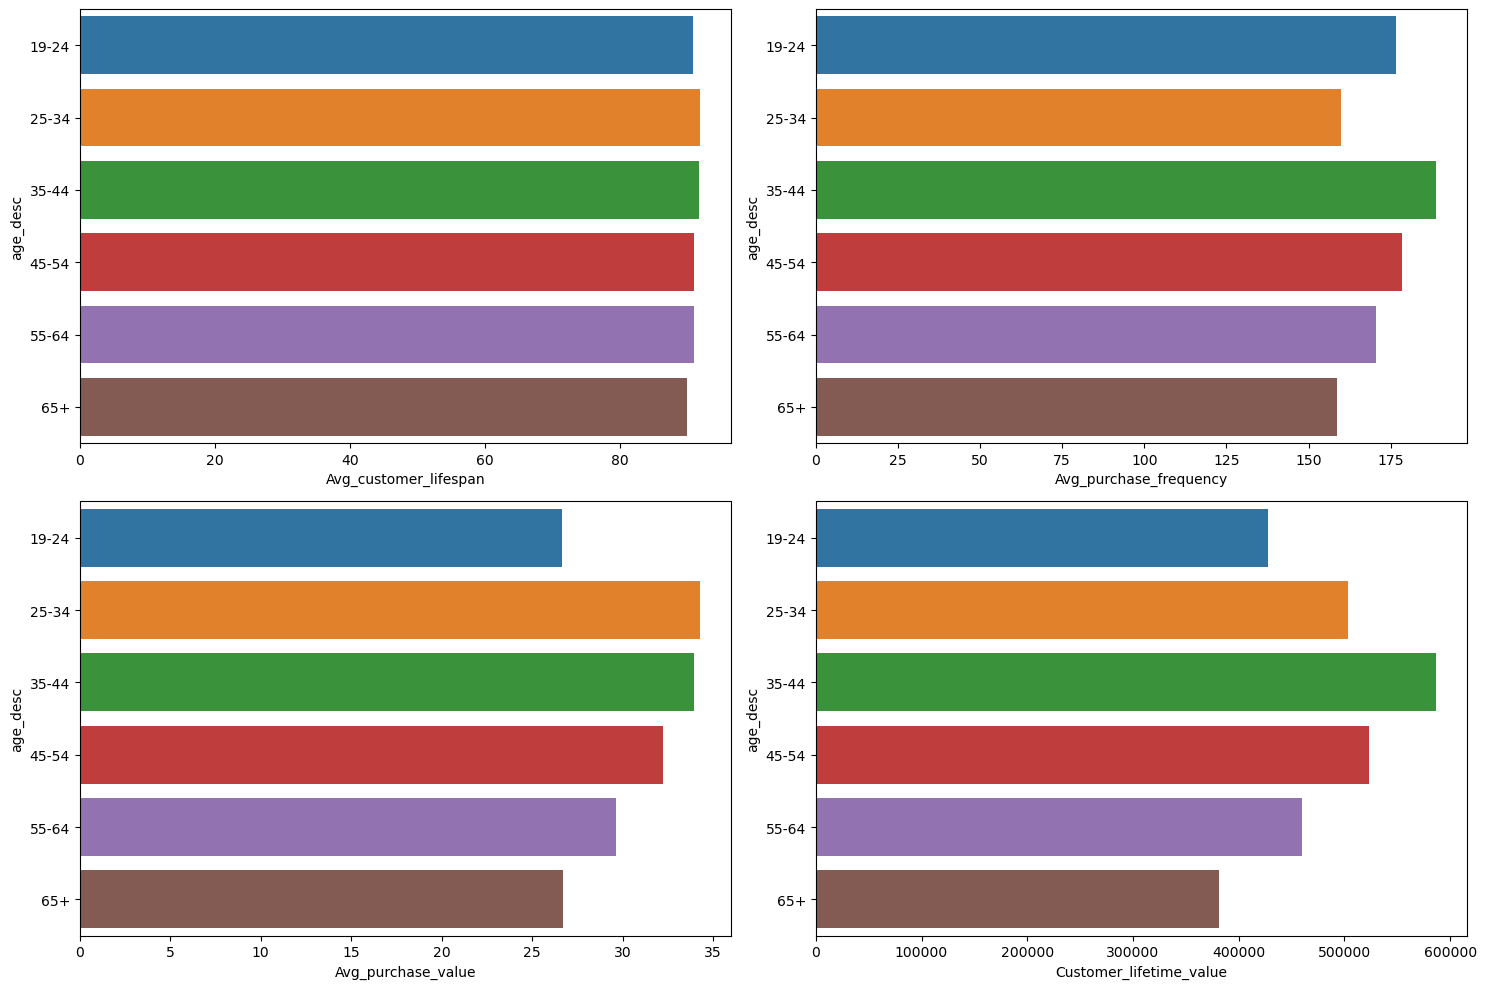

In [63]:
plt.figure(0,figsize=(15,10))
j=1
for i in clv.columns[1:]:
    plt.subplot(2,2,j)
    sns.barplot(data=clv,x=i,y="age_desc")
    j+=1
plt.tight_layout()